# Detecting Breast Cancer

One interesting application of machine learning is in the area of medical diagnoses. Implement Neural Network in python to classify the data into Benign or Malignant for the Wisconsin Diagnostic Breast Cancer (WDBC) dataset. 

### Things to keep in mind: 
* How will you choose the features? 
* How will you train, validate, and test your model?
* How will you overcome overfitting?

### Write-up
In your write-up, please attach training curves, final losses, and visualizations of errors made by the trained model, along with a description of the methods/tricks you tried to improve performance.


In [ ]:
import numpy as np
import pandas as pd

import torch

In [ ]:
DATASET_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
COLUMN_NAMES = [
  'Sample code number',
  'Clump Thickness',
  'Uniformity of Cell Size',
  'Uniformity of Cell Shape',
  'Marginal Adhesion',
  'Single Epithelial Cell Size',
  'Bare Nuclei',
  'Bland Chromatin',
  'Normal Nucleoli',
  'Mitoses',
  'Class',
]
dataset = pd.read_csv(DATASET_URL, names=COLUMN_NAMES)

## Dataset description


|  Attribute               |     	 	Domain |
|--- | ---|
|   1. Sample code number |           	id number|
|   2. Clump Thickness     |          	1 - 10|
|   3. Uniformity of Cell Size |      	1 - 10|
|   4. Uniformity of Cell Shape |     	1 - 10|
|   5. Marginal Adhesion         |    	1 - 10|
|   6. Single Epithelial Cell Size |  	1 - 10|
|   7. Bare Nuclei       |            		1 - 10
|   8. Bland Chromatin  |             		1 - 10
|   9. Normal Nucleoli |              		1 - 10
|  10. Mitoses   |                    		1 - 10
|  11. Class:    |                    		(2 for benign, 4 for malignant)|

In [ ]:
dataset.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [ ]:
# Normalize your dataset, and split your dataset between test, train, and validation

dataset['Clump Thickness'] = dataset['Clump Thickness'] / np.max(dataset['Clump Thickness'])
dataset['Uniformity of Cell Size'] = dataset['Uniformity of Cell Size'] / np.max(dataset['Uniformity of Cell Size'])
dataset['Uniformity of Cell Shape'] = dataset['Uniformity of Cell Shape'] / np.max(dataset['Uniformity of Cell Shape'])
dataset['Marginal Adhesion'] = dataset['Marginal Adhesion'] / np.max(dataset['Marginal Adhesion'])
dataset['Single Epithelial Cell Size'] = dataset['Single Epithelial Cell Size'] / np.max(dataset['Single Epithelial Cell Size'])
dataset['Bare Nuclei'] = dataset['Bare Nuclei'].replace('?', 0)
dataset['Bare Nuclei'] = pd.to_numeric(dataset['Bare Nuclei'])
dataset['Bare Nuclei'] = dataset['Bare Nuclei'] / np.max(dataset['Bare Nuclei'])
dataset['Bland Chromatin'] = dataset['Bland Chromatin'] / np.max(dataset['Bland Chromatin'])
dataset['Normal Nucleoli'] = dataset['Normal Nucleoli'] / np.max(dataset['Normal Nucleoli'])
dataset['Mitoses'] = dataset['Mitoses'] / np.max(dataset['Mitoses'])
dataset['Class'] = dataset['Class'].replace(2, 0)
dataset['Class'] = dataset['Class'].replace(4, 1)

In [ ]:
dataset = dataset.drop('Sample code number', axis=1)   # drop the unused sample code number column.

In [ ]:
train_val_data = dataset.sample(frac=0.8, random_state=0, axis=0)   # 20% data for testing
test_data = dataset[~dataset.index.isin(train_val_data.index)]
train_data = train_val_data.sample(frac=0.9, random_state=0, axis=0)  # 72% data for training
val_data = train_val_data[~train_val_data.index.isin(train_data.index)]   # 8% data for validation

In [ ]:
from torch.autograd import Variable 

train_x = torch.from_numpy(train_data[dataset.columns[0:9]].values).type(torch.FloatTensor)
val_x = torch.from_numpy(val_data[dataset.columns[0:9]].values).type(torch.FloatTensor) 
test_x = torch.from_numpy(test_data[dataset.columns[0:9]].values).type(torch.FloatTensor) 
train_y = torch.from_numpy(train_data[dataset.columns[9]].values).type(torch.LongTensor)
val_y = torch.from_numpy(val_data[dataset.columns[9]].values).type(torch.LongTensor)
test_y = torch.from_numpy(test_data[dataset.columns[9]].values).type(torch.LongTensor)
train_x, train_y = Variable(train_x), Variable(train_y) 
test_x, test_y = Variable(test_x), Variable(test_y) 
val_x, val_y = Variable(val_x), Variable(val_y) 

In [ ]:
# Define you model here

class FCNet(torch.nn.Module):
  '''
  Use a shallow fully-connected network
  '''
  def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
    super(FCNet, self).__init__()
    self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)
    self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
    self.out = torch.nn.Linear(n_hidden2, n_output)
    self.relu = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(0.25)
  
  def forward(self, x):
    x = self.relu(self.hidden1(x))
    x = self.dropout(x)
    x = self.relu(self.hidden2(x))
    x = self.dropout(x)
    x = self.out(x)
    return x

SimpleModel = FCNet(9, 32, 16, 2)

In [ ]:
# Train your model

LR = 0.001
EPOCHS = 500
BATCH_SIZE = 10

optimizer = torch.optim.SGD(SimpleModel.parameters(), lr = LR)   # use SGD with learning rate 0.1
loss_fn = torch.nn.CrossEntropyLoss()
loss_train = []
loss_val = []
acc_val = []
epochs = []
min_valloss = np.inf
for epoch in range(EPOCHS):
  epochs.append(epoch)
  loss_array = []
  # train
  for i in range(0, train_x.shape[0], BATCH_SIZE):
    if(i+BATCH_SIZE > train_x.shape[0]):
      x = train_x[i:train_x.shape[0]]
      y = train_y[i:train_x.shape[0]]
    else:
      x = train_x[i:i+BATCH_SIZE]
      y = train_y[i:i+BATCH_SIZE]
    out = SimpleModel(x)
    loss = loss_fn(out, y)
    loss_array.append(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss = np.mean(np.array(loss_array))
  loss_train.append(loss)
  
  # validation
  x = val_x
  y = val_y
  out = SimpleModel(x)
  _, preds = torch.max(out, 1)
  val_accuracy = np.sum(np.array(preds) == np.array(y)) / y.shape[0]
  # print(val_accuracy)
  acc_val.append(val_accuracy)
  loss = loss_fn(out, y)
  loss_val.append(float(loss))
  if(float(loss) < min_valloss):
    min_valloss = float(loss)
    BestModel = SimpleModel  #  storage for best model
print("The best loss (final loss) for validation set is: " + str(min_valloss))
print(BestModel)

The best loss (final loss) for validation set is: 0.11944297701120377
FCNet(
  (hidden1): Linear(in_features=9, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
# Test your model 

x = test_x
y = test_y
out = BestModel(x)
test_loss = float(loss_fn(out, y))
_, preds = torch.max(out, 1)
test_accuracy = np.sum(np.array(preds) == np.array(y)) / y.shape[0]
print("The test accuracy is: " + str(test_accuracy))
print("The test loss is: " + str(test_loss))

The test accuracy is: 0.9642857142857143
The test loss is: 0.09724803268909454


Text(0.5, 1.0, 'Training/validation loss vs number of epochs')

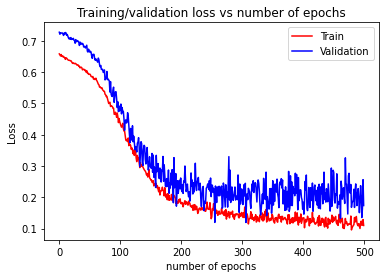

In [ ]:
# Draw training curves, and visualizations of errors made by the trained model

import matplotlib.pyplot as plt

plt.plot(epochs, loss_train, c='r')
plt.plot(epochs, loss_val, c='b')
plt.xlabel('number of epochs')
plt.ylabel('Loss')
plt.legend(["Train","Validation"],loc='upper right')
plt.title('Training/validation loss vs number of epochs')

Text(0.5, 1.0, 'Validation accuracy vs number of epochs')

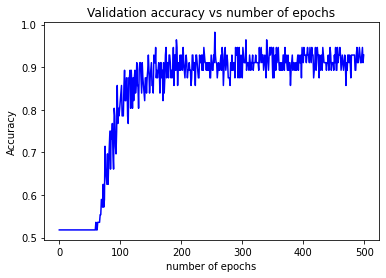

In [ ]:
plt.plot(epochs, acc_val, c='b')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Validation accuracy vs number of epochs')